In [9]:
import cv2
import os
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# Path to query and database image folders
query_folder = "D:/NYU/1-3/RobotPerception/HW2/data/task5/task_5/query/"
database_folder = "D:/NYU/1-3/RobotPerception/HW2/data/task5/task_5/database/"

# Load all query and database image paths
query_images = [os.path.join(query_folder, img) for img in os.listdir(query_folder)]
database_images = [os.path.join(database_folder, img) for img in os.listdir(database_folder)]

In [10]:
def extract_features_orb(image_path):
    """Extract ORB features from an image."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(img, None)
    return keypoints, descriptors

In [13]:
# Extract features for query images
query_descriptors = [extract_features_orb(q) for q in query_images]

# Extract features for database images
database_descriptors = {db: extract_features_orb(db) for db in database_images}

In [16]:
def match_orb_features(query_desc, db_desc):
    """Match features using FLANN-based matcher."""
    if query_desc is None or db_desc is None:
        return None, 0
    
    # Define FLANN parameters
    FLANN_INDEX_LSH = 6
    index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
    search_params = dict(checks=50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(query_desc, db_desc, k=2)
    
    # Ratio test as per Lowe's paper
    good_matches = []
    for match_pair in matches:
        if len(match_pair) < 2:
            continue  # Skip if fewer than 2 matches
        m, n = match_pair
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    
    return good_matches, len(good_matches)


In [17]:
results = {}

for query_path in query_images:
    q_keypoints, q_descriptors = extract_features_orb(query_path)
    best_match = None
    best_score = -1
    
    for db_path, (db_keypoints, db_descriptors) in database_descriptors.items():
        matches, score = match_orb_features(q_descriptors, db_descriptors)
        if score > best_score:
            best_score = score
            best_match = db_path
    
    results[query_path] = (best_match, best_score)



Query Image: D:/NYU/1-3/RobotPerception/HW2/data/task5/task_5/query/query_1.jpg matched with D:/NYU/1-3/RobotPerception/HW2/data/task5/task_5/database/dr5rsn0yet6m-dr5rsn0ympkm-cds-3670f40ef7987d5a-20161022-1109-395.jpg (Score: 495)


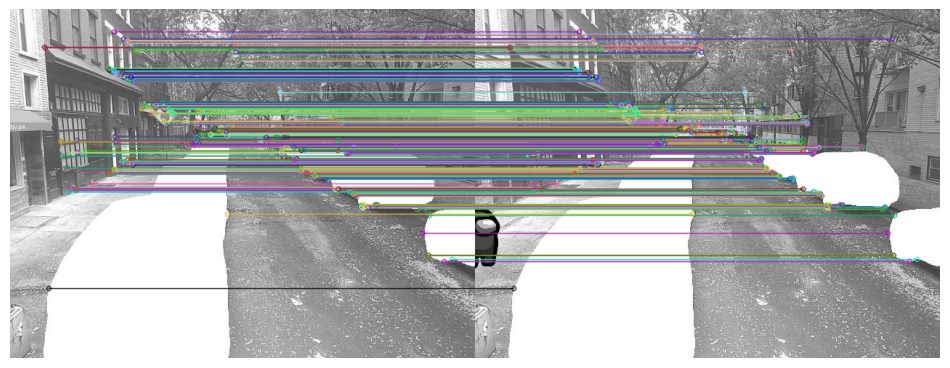

Query Image: D:/NYU/1-3/RobotPerception/HW2/data/task5/task_5/query/query_2.jpg matched with D:/NYU/1-3/RobotPerception/HW2/data/task5/task_5/database/dr5rsn1tgm9f-dr5rsn1tggkn-cds-22ecab6d4a71bfcf-20160901-1157-7188.jpg (Score: 458)


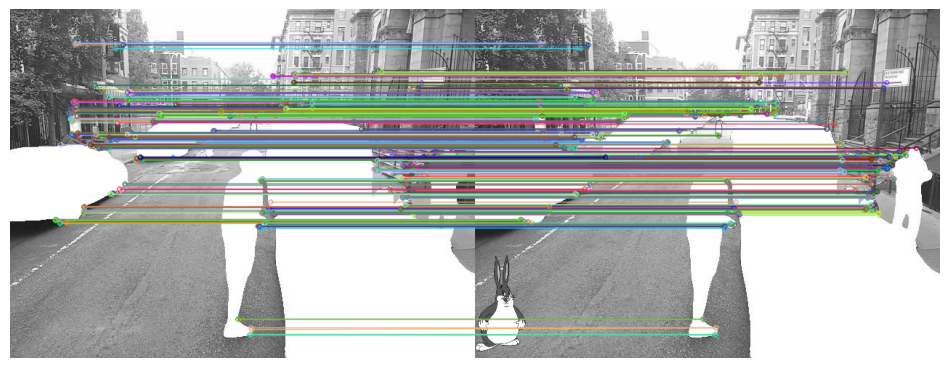

Query Image: D:/NYU/1-3/RobotPerception/HW2/data/task5/task_5/query/query_3.jpg matched with D:/NYU/1-3/RobotPerception/HW2/data/task5/task_5/database/dr5rsn1w5bcx-dr5rsn1tuppy-cds-22ecab6d4a71bfcf-20160901-1157-7368.jpg (Score: 485)


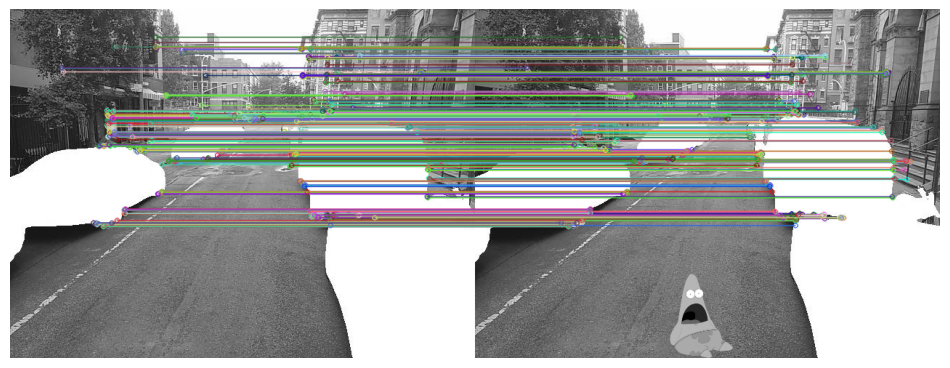

In [18]:
def visualize_orb_matches(query_path, matched_path):
    """Visualize matches between query and matched image."""
    query_img = cv2.imread(query_path, cv2.IMREAD_GRAYSCALE)
    matched_img = cv2.imread(matched_path, cv2.IMREAD_GRAYSCALE)
    
    # Extract features
    q_keypoints, q_descriptors = extract_features_orb(query_path)
    m_keypoints, m_descriptors = extract_features_orb(matched_path)
    
    # Match features
    flann = cv2.FlannBasedMatcher(dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=1), dict(checks=50))
    matches = flann.knnMatch(q_descriptors, m_descriptors, k=2)
    
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    
    # Draw matches
    matched_img = cv2.drawMatches(query_img, q_keypoints, matched_img, m_keypoints, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(12, 6))
    plt.imshow(matched_img, cmap='gray')
    plt.axis('off')
    plt.show()

# Show matches for all results
for query_image, (matched_image, score) in results.items():
    print(f"Query Image: {query_image} matched with {matched_image} (Score: {score})")
    visualize_orb_matches(query_image, matched_image)


In [21]:
path_image =  "D:/NYU/1-3/RobotPerception/HW2/data/task5/task_5/database/dr5rsn1w5bcx-dr5rsn1tuppy-cds-22ecab6d4a71bfcf-20160901-1157-7368.jpg"

image = cv2.imread(path_image, cv2.IMREAD_GRAYSCALE)
cv2.imshow("image",image)
cv2.waitKey(0)
cv2.destroyAllWindows()